# =================
# 정답값과 비교하기 위한 코드 분석 다시!

In [12]:
import torch
from pathlib import Path

# 1. 저장된 디렉토리 경로
save_dir = '/workspace/chanyoung/code/MODU/output/lulu/kiosk/tiny_250411/query'

# 2. 이미지 단위 리스트 초기화
queries_per_image = []
logits_per_image = []
boxes_per_image = []
targets_per_image = []

# 3. 파일 순회
for file in sorted(Path(save_dir).glob("step_*.pt")):
    data = torch.load(file, map_location='cpu')

    queries = data['queries']     # (B, Q, D)
    logits = data['logits']       # (B, Q, C)
    boxes = data.get('boxes', None)   # (B, Q, 4) or None
    targets = data.get('targets', []) # list of dicts, len = B

    B = queries.size(0)

    for i in range(B):
        queries_per_image.append(queries[i])     # (Q, D)
        logits_per_image.append(logits[i])       # (Q, C)

        if boxes is not None:
            boxes_per_image.append(boxes[i])     # (Q, 4)
        else:
            boxes_per_image.append(None)

        if i < len(targets):
            targets_per_image.append(targets[i])
        else:
            targets_per_image.append({})  # 빈 dict fallback


/tmp/ipykernel_25014/4187598058.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file, map_location='cpu')


In [13]:
print("Number of images:", len(queries_per_image))
print(queries_per_image[0].shape, logits_per_image[0].shape, boxes_per_image[0].shape, targets_per_image[0].keys())

Number of images: 948
torch.Size([300, 256]) torch.Size([300, 2]) torch.Size([300, 4]) dict_keys(['boxes', 'labels', 'image_id', 'area', 'iscrowd', 'orig_size', 'size'])


In [14]:
import torch

def box_cxcywh_to_xyxy(boxes):
    # boxes: (N, 4), format: cx, cy, w, h (normalized 0~1)
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack([x1, y1, x2, y2], dim=-1)

def box_iou(boxes1, boxes2):
    # boxes1, boxes2: (N, 4), (M, 4)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # (N, M, 2)
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # (N, M, 2)

    wh = (rb - lt).clamp(min=0)  # (N, M, 2)
    inter = wh[:, :, 0] * wh[:, :, 1]  # (N, M)

    union = area1[:, None] + area2 - inter
    iou = inter / union
    return iou  # (N, M)


def get_prediction_results(logits, pred_boxes, targets, image_size=(640, 640)):
    W, H = image_size

    # Step 1: Box 변환 및 스케일
    pred_boxes_xyxy = box_cxcywh_to_xyxy(pred_boxes)
    pred_boxes_xyxy[:, [0, 2]] *= W
    pred_boxes_xyxy[:, [1, 3]] *= H

    gt_boxes = targets["boxes"]  # (num_gt, 4)
    gt_labels = targets["labels"]  # (num_gt,)

    # Step 2: IoU 계산
    ious = box_iou(pred_boxes_xyxy, gt_boxes)  # (300, num_gt)

    # Step 3: 예측 클래스 판단
    probs = torch.sigmoid(logits)  # (300, 2)
    max_probs, raw_preds = probs.max(dim=1)
    is_object = (probs >= 0.5).any(dim=1)

    pred_class = torch.zeros_like(raw_preds)
    pred_class[is_object] = raw_preds[is_object] + 1  # 배경은 0, 나머지는 1 or 2

    pred_logits = torch.zeros_like(max_probs)
    pred_logits[is_object] = probs[is_object, raw_preds[is_object]]
    pred_logits[~is_object] = 1.0 - max_probs[~is_object]

    # Step 4: 1차 gt_class 계산
    gt_class = torch.zeros(logits.shape[0], dtype=torch.long)
    matched_gt = torch.full((len(gt_boxes),), -1, dtype=torch.long)  # 각 GT별로 가장 잘 매칭된 query 인덱스 저장

    for i in range(logits.shape[0]):
        iou_row = ious[i]
        if iou_row.numel() == 0 or iou_row.max() < 0.5:
            continue
        matched_idx = iou_row.argmax()
        matched_label = gt_labels[matched_idx]
        gt_class[i] = matched_label + 1

        # 최고 IoU 기록
        if matched_gt[matched_idx] == -1 or iou_row[matched_idx] > ious[matched_gt[matched_idx], matched_idx]:
            matched_gt[matched_idx] = i  # 더 높은 IoU면 교체

    # Step 5: 배경인데 IoU 0.5 이상인 경우 → 다른 query가 이미 더 잘 맞췄다면 gt_class = 0
    for i in range(logits.shape[0]):
        if pred_class[i] != 0:
            continue  # 배경만 확인
        iou_row = ious[i]
        if iou_row.numel() == 0 or iou_row.max() < 0.5:
            continue
        matched_idx = iou_row.argmax()
        best_query_for_gt = matched_gt[matched_idx]
        if best_query_for_gt != i:
            gt_class[i] = 0  # 이 query는 무시

    return pred_class, pred_logits, gt_class


In [15]:
pred_class, pred_logits, gt_class = get_prediction_results(
    logits=logits_per_image[0],
    pred_boxes=boxes_per_image[0],
    targets=targets_per_image[0],
    image_size=(640, 640)
)
print(pred_class.shape, pred_logits.shape, gt_class.shape)
print(pred_class[:10], pred_logits[:10], gt_class[:10])

torch.Size([300]) torch.Size([300]) torch.Size([300])
tensor([1, 1, 1, 2, 1, 1, 1, 1, 1, 1]) tensor([0.7143, 0.7271, 0.7358, 0.6450, 0.6496, 0.6287, 0.6804, 0.6394, 0.5682,
        0.6209]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [16]:
all_queries = []
all_pred_classes = []
all_pred_logits = []
all_gt_classes = []

for i in range(len(queries_per_image)):
    queries = queries_per_image[i]         # (300, 256)
    logits = logits_per_image[i]           # (300, 2)
    boxes = boxes_per_image[i]             # (300, 4)
    targets = targets_per_image[i]         # dict with 'boxes', 'labels', ...

    pred_class, pred_logit, gt_class = get_prediction_results(
        logits=logits,
        pred_boxes=boxes,
        targets=targets,
        image_size=(640, 640)
    )

    # 누적 저장
    all_queries.append(queries)                     # (300, 256)
    all_pred_classes.append(pred_class)             # (300,)
    all_pred_logits.append(pred_logit)              # (300,)
    all_gt_classes.append(gt_class)                 # (300,)

# 최종적으로 하나의 텐서로 합치기
all_queries = torch.cat(all_queries, dim=0)             # (N_total, 256)
all_pred_classes = torch.cat(all_pred_classes, dim=0)   # (N_total,)
all_pred_logits = torch.cat(all_pred_logits, dim=0)     # (N_total,)
all_gt_classes = torch.cat(all_gt_classes, dim=0)       # (N_total,)
print(all_queries.shape, all_pred_classes.shape, all_pred_logits.shape, all_gt_classes.shape)


torch.Size([284400, 256]) torch.Size([284400]) torch.Size([284400]) torch.Size([284400])


## 분류 정확도

In [17]:
from sklearn.metrics import accuracy_score

# all_pred_classes, all_gt_classes: torch.Tensor 형태라고 가정
accuracy = accuracy_score(all_gt_classes.numpy(), all_pred_classes.numpy())
print(f"분류 정확도: {accuracy:.2%}")


분류 정확도: 88.85%


## confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_gt_classes.numpy(), all_pred_classes.numpy(), labels=[0, 1, 2])
print("🧩 Confusion Matrix:")
print("          Pred_0   Pred_1   Pred_2")
print(f"GT_0     {cm[0,0]:8} {cm[0,1]:8} {cm[0,2]:8}")
print(f"GT_1     {cm[1,0]:8} {cm[1,1]:8} {cm[1,2]:8}")
print(f"GT_2     {cm[2,0]:8} {cm[2,1]:8} {cm[2,2]:8}")


🧩 Confusion Matrix:
          Pred_0   Pred_1   Pred_2
GT_0       252617     7500    23897
GT_1           84       13        9
GT_2          216        4       60


In [8]:
# cm: confusion matrix (shape: [3, 3])
precision_list = []
recall_list = []
f1_list = []

num_classes = cm.shape[0]

for cls in range(num_classes):
    tp = cm[cls, cls]
    fp = cm[:, cls].sum() - tp
    fn = cm[cls, :].sum() - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# 출력
for i in range(num_classes):
    print(f"Class {i} (0:배경, 1:클래스0, 2:클래스1)")
    print(f"  Precision: {precision_list[i]:.4f}")
    print(f"  Recall   : {recall_list[i]:.4f}")
    print(f"  F1 Score : {f1_list[i]:.4f}")
    print()

# 평균 (macro)
macro_precision = sum(precision_list) / num_classes
macro_recall = sum(recall_list) / num_classes
macro_f1 = sum(f1_list) / num_classes

print("📊 Macro Averages")
print(f"  Precision: {macro_precision:.4f}")
print(f"  Recall   : {macro_recall:.4f}")
print(f"  F1 Score : {macro_f1:.4f}")


Class 0 (0:배경, 1:클래스0, 2:클래스1)
  Precision: 0.9988
  Recall   : 0.8895
  F1 Score : 0.9410

Class 1 (0:배경, 1:클래스0, 2:클래스1)
  Precision: 0.0017
  Recall   : 0.1226
  F1 Score : 0.0034

Class 2 (0:배경, 1:클래스0, 2:클래스1)
  Precision: 0.0025
  Recall   : 0.2143
  F1 Score : 0.0049

📊 Macro Averages
  Precision: 0.3343
  Recall   : 0.4088
  F1 Score : 0.3164


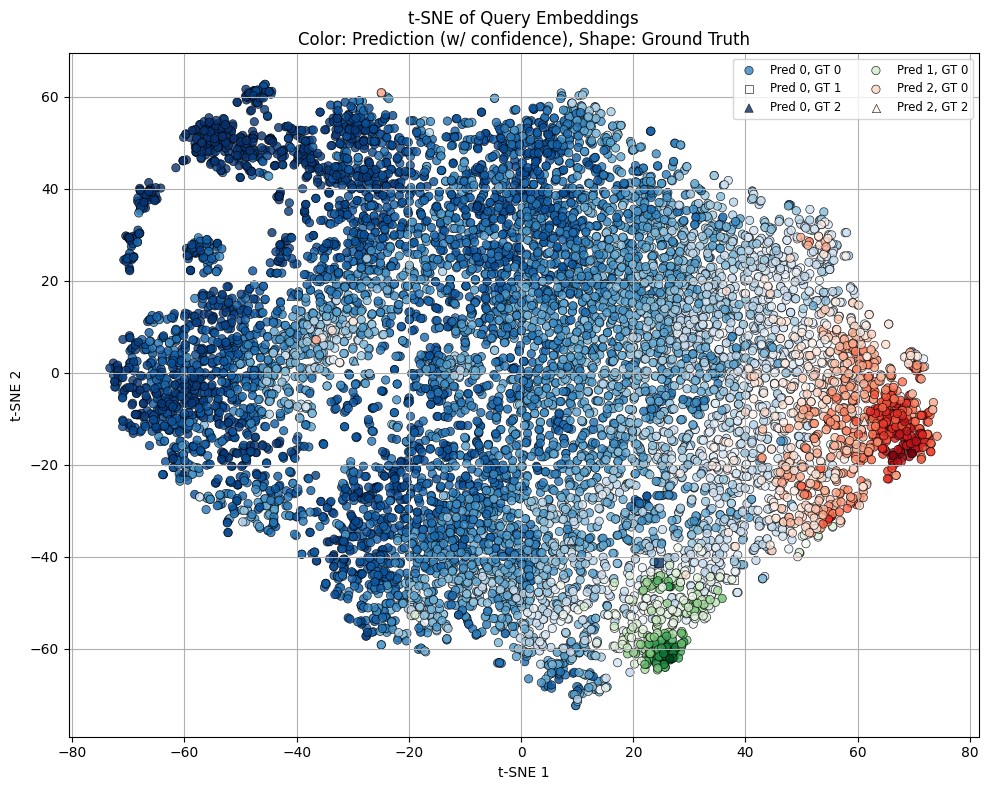

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 필요 시 일부 샘플만 추출 (속도 & 메모리 고려)
max_samples = 10000
N = all_queries.shape[0]
indices = torch.randperm(N)[:max_samples]

queries_sample = all_queries[indices].numpy()
pred_class_sample = all_pred_classes[indices].numpy()
pred_logits_sample = all_pred_logits[indices].numpy()
gt_class_sample = all_gt_classes[indices].numpy()

# t-SNE 수행
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
query_embeddings_2d = tsne.fit_transform(queries_sample)

# 색깔 계열 (예측 클래스별)
colors = {0: "Blues", 1: "Greens", 2: "Reds"}
# 마커 모양 (GT 클래스별)
markers = {0: "o", 1: "s", 2: "^"}

# 시각화
plt.figure(figsize=(10, 8))
for cls in [0, 1, 2]:
    for gt in [0, 1, 2]:
        mask = (pred_class_sample == cls) & (gt_class_sample == gt)
        if np.sum(mask) == 0:
            continue
        plt.scatter(
            query_embeddings_2d[mask, 0],
            query_embeddings_2d[mask, 1],
            c=pred_logits_sample[mask],
            cmap=colors[cls],
            marker=markers[gt],
            edgecolors='k',
            linewidths=0.5,
            alpha=0.8,
            label=f"Pred {cls}, GT {gt}"
        )

plt.title("t-SNE of Query Embeddings\nColor: Prediction (w/ confidence), Shape: Ground Truth")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(loc='best', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


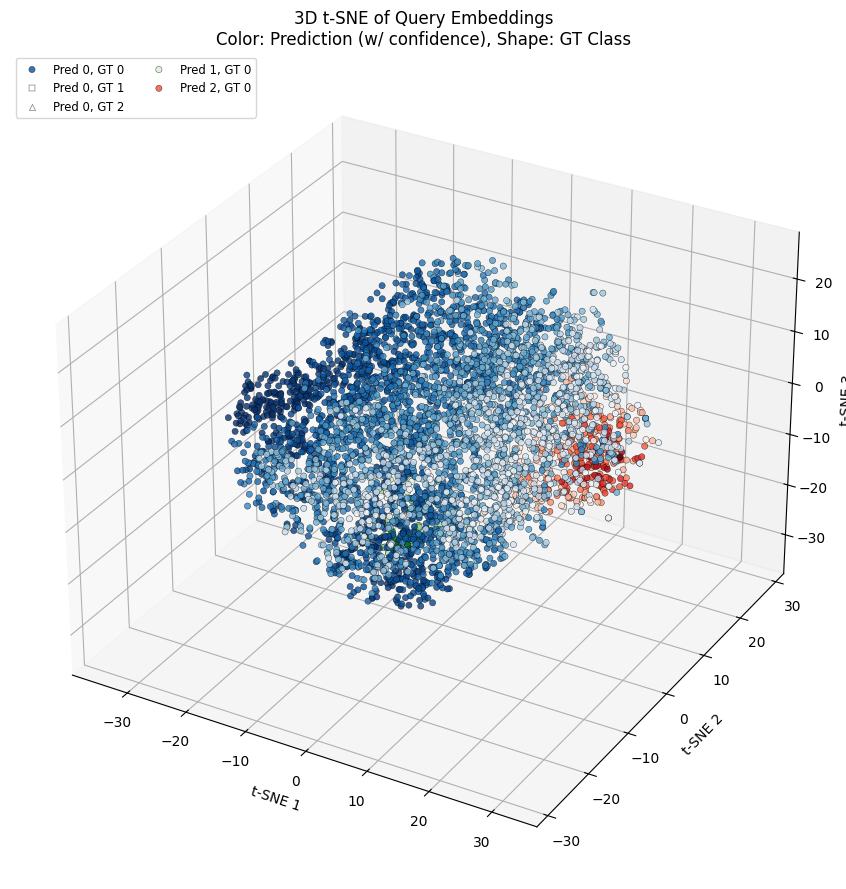

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 샘플링
max_samples = 5000
N = all_queries.shape[0]
indices = torch.randperm(N)[:max_samples]

queries_sample = all_queries[indices].numpy()
pred_class_sample = all_pred_classes[indices].numpy()
pred_logits_sample = all_pred_logits[indices].numpy()
gt_class_sample = all_gt_classes[indices].numpy()

# t-SNE (3D)
tsne = TSNE(n_components=3, random_state=42, perplexity=30, learning_rate=200)
query_embeddings_3d = tsne.fit_transform(queries_sample)

# 색깔 계열 (예측 클래스별)
colors = {0: "Blues", 1: "Greens", 2: "Reds"}
# 마커 모양 (GT 클래스별)
markers = {0: "o", 1: "s", 2: "^"}

# 시각화
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for cls in [0, 1, 2]:
    for gt in [0, 1, 2]:
        mask = (pred_class_sample == cls) & (gt_class_sample == gt)
        if np.sum(mask) == 0:
            continue
        sc = ax.scatter(
            query_embeddings_3d[mask, 0],
            query_embeddings_3d[mask, 1],
            query_embeddings_3d[mask, 2],
            c=pred_logits_sample[mask],
            cmap=colors[cls],
            marker=markers[gt],
            edgecolors='k',
            linewidths=0.3,
            alpha=0.8,
            label=f"Pred {cls}, GT {gt}"
        )

ax.set_title("3D t-SNE of Query Embeddings\nColor: Prediction (w/ confidence), Shape: GT Class")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()
